# CSE 252A Computer Vision I Fall 2022 - Assignment 3

## Instructor: Ben Ochoa

- Assignment Published On: **Wed, November 2, 2022**.

- Due: **Wed, November 16, 2022 11:59 PM**.

## Instructions
* This assignment must be completed **individually**. For more details, please follow the Academic Integrity Policy and Collaboration Policy on [Canvas](https://canvas.ucsd.edu).
* All solutions must be written in this notebook.
  * **If** it includes the theoretical problems, you **must** write your answers in Markdown cells (using LaTeX when appropriate).
  * Programming aspects of the assignment must be completed using Python in this notebook.
* You may use Python packages (such as `NumPy` and `SciPy`) for basic linear algebra, but you may not use packages that directly solve the problem.
  * If you are unsure about using a specific package or function, then ask the instructor and/or teaching assistants for clarification.
* You must submit this notebook exported as a PDF that contains separate pages. You must also submit this notebook as `.ipynb` file.
  * Submit both files (`.pdf` and `.ipynb`) on Gradescope.
  * **You must mark the PDF pages associated with each question in Gradescope. If you fail to do so, we may dock points.**
* It is highly recommended that you begin working on this assignment early.
* **Late Policy:** Assignments submitted late will receive a 15% grade reduction for each 12 hours late (i.e., 30% per day). Assignments will not be accepted 72 hours after the due date. If you require an extension (for personal reasons only) to a due date, you must request one as far in advance as possible. Extensions requested close to or after the due date will only be granted for clear emergencies or clearly unforeseeable circumstances. 

## Problem 1: Multiscale image representations [15 pts]

In the [Lecture 9](https://cseweb.ucsd.edu/classes/fa22/cse252A-a/lec9.pdf), given an image, we compare its multiscale representation generated by **Gaussian Image Pyramid** and **Scale-space** methods. The task for this problem is to first build multiscale representations for image `p1/totoro.jpg`, then **comment on** your results obtained by generating a Gaussian pyramid for an image versus those obtained by generating its scale-space representation.

For the Gaussian pyramid, use a binomial kernel of size 5x5 as an approximation for the Gaussian filter. The sampling rate between levels is $rate=2$. 

For the scale-space representation, use a Gaussian filter where the standard deviation depends on the corresponding level of the pyramid (**Hint:** standard deviation $\sigma =  2^{level-1}$, for $level>0$). 

Look at the lecture slides to see the correspondence between pyramid levels and standard deviation for the Gaussian filter in scale space. Also, remember the Gaussian filter dimension is $\lceil 6 \sigma \rceil$ for standard deviation $\sigma$. If the result is an even number, then add 1 to make it odd. 

You need to construct the pyramid and scale-space representation from level 0 to level 9. Note that level 0 is just the original image in both the representations.

Use the provided plotting function to visualize the results.

In [ ]:
!unzip /content/CSE252A_FA_2022_assignment_3.zip

Archive:  /content/CSE252A_FA_2022_assignment_3.zip
   creating: fig/
  inflating: fig/eg_dino_epipolar_lines.png  
  inflating: fig/eg_dino_sift.png    
  inflating: fig/eg_dino_sift_matching.png  
 extracting: fig/eg_pc_sift.PNG      
  inflating: fig/exp_house_rectify.png  
  inflating: fig/sample_optical_flow_output.PNG  
   creating: p1/
  inflating: p1/totoro.jpg           
   creating: p2/
   creating: p2/dino/
  inflating: p2/dino/cor1.npy        
  inflating: p2/dino/cor2.npy        
 extracting: p2/dino/dino0.png       
 extracting: p2/dino/dino1.png       
 extracting: p2/dino/proj1.npy       
 extracting: p2/dino/proj2.npy       
   creating: p2/matrix/
  inflating: p2/matrix/cor1.npy      
  inflating: p2/matrix/cor2.npy      
  inflating: p2/matrix/cor3.npy      
  inflating: p2/matrix/cor4.npy      
 extracting: p2/matrix/matrix0.png   
 extracting: p2/matrix/matrix1.png   
 extracting: p2/matrix/proj1.npy     
 extracting: p2/matrix/proj2.npy     
   creating: p2/warrio

In [ ]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve
import scipy.special
from skimage import io
import copy

def gaussian2d(sig):
    filter_size = int(sig * 6)
    if filter_size % 2 == 0:
        filter_size += 1
    ax = np.arange(-filter_size // 2 + 1., filter_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))
    return kernel / np.sum(kernel)

def gaussian_filter(img,sig):
    """Blur the image by convolving with a Gaussian filter."""
    blurred_img = np.zeros_like(img)
    kernel = gaussian2d(sig)
    blurred_img = convolve(img,kernel,mode='same')
    return blurred_img

def binomial_kernel(size):
    """Creates a binomial filter kernel"""
    coeffs = np.array([scipy.special.binom(size, i) for i in range(size+1)]).reshape((-1,1))
    kernel = np.repeat(coeffs, repeats=size+1, axis=1).T
    kernel = kernel * coeffs
    return kernel/np.sum(kernel)


In [ ]:
def normalize(img):
  assert img.shape[2] == 3
  maxi = img.max()
  mini = img.min()
  return (img - mini)/(maxi-mini)

def mirror_pad(image, pad_size):
  tmp = image
  for i in range(pad_size):
    a = tmp
    b = image[:,-2-i]
    b = b.reshape(-1,1)
    tmp = np.hstack((a,b))
  
  image = tmp 
  for i in range(pad_size):
    a = tmp
    b = image[:,i+1]
    b = b.reshape(-1,1)
    tmp = np.hstack((b,a))

  image = tmp 
  
  for i in range(pad_size):
    a = tmp
    b = image[i+1,:]
    b = b.reshape(1,-1)
    tmp = np.vstack((b,a))
  
  image = tmp 
  
  for i in range(pad_size):
    a = tmp
    b = image[-2-i,:]
    b = b.reshape(1,-1)
    tmp = np.vstack((a,b))
  
  image = tmp 

  return image

In [ ]:
image = [[1,2,3,4,5],
         [6,7,8,9,10],
         [11,12,13,14,15],
         [16,17,18,19,20]]

image=np.array(image)

print(mirror_pad(image,2))

[[13 12 11 12 13 14 15 14 13]
 [ 8  7  6  7  8  9 10  9  8]
 [ 3  2  1  2  3  4  5  4  3]
 [ 8  7  6  7  8  9 10  9  8]
 [13 12 11 12 13 14 15 14 13]
 [18 17 16 17 18 19 20 19 18]
 [13 12 11 12 13 14 15 14 13]
 [ 8  7  6  7  8  9 10  9  8]]


In [ ]:
def gaussian_pyramid(img, num_levels = 9):
  pyramid = []
  pyramid.append(img.copy()) # level-0 image
  for i in range(1,num_levels+1):
    image = pyramid[i-1].copy()
    newheight = image.shape[0]//2
    newwidth =image.shape[1]//2
    if image.shape[0] % 2 == 1:
        newheight = image.shape[0]//2+1
    if image.shape[1] % 2 == 1:
        newwidth = image.shape[1]//2+1 
    out = np.zeros((newheight,newwidth,3))
    kernel = binomial_kernel(4) # to produce a 5x5 filter
    Hi, Wi , c = image.shape
    Hk, Wk = kernel.shape
    for i in range(3):
      tmp = mirror_pad(image[:,:,i],(Hk-1)//2)
      image[:,:,i] = convolve(tmp, kernel,mode='valid')
    out = image[::2,::2,:]
    pyramid.append(out)    
  return pyramid

In [ ]:
def scale_space(img, num_levels = 9):
  scale_space = []
  scale_space.append(img.copy()) # std = 0, level-0 image
  for i in range(1, num_levels+1):
    image = scale_space[i-1].copy()
    std = 2**(i-1)
    size = 6*std+1
    kernel = gaussian2d(std)
    Hi, Wi , c = image.shape
    Hk, Wk = kernel.shape
    for i in range(3):
      tmp = mirror_pad(image[:,:,i],(Hk-1)//2)
      image[:,:,i] = convolve(tmp, kernel,mode='valid')       
    scale_space.append(image)
  return scale_space

In [ ]:
def plot_results(pyramid, scale_space):        
    
    print("\t\tGaussian Pyramid\t\t\t Scale Space Representation")
    
    N = len(pyramid)
    std_list = [0] + [2**i for i in range(N-1)]
    for i in range(N):
        pyramid_img = pyramid[i]
        scale_space_img = scale_space[i]
        
        fig = plt.figure(figsize=(12, 9))
        
        ax1 = fig.add_subplot(221)
        ax1.imshow(pyramid_img)
        ax1.axis('off')
        plt.title("Level {}".format(i))
        
        ax2 = fig.add_subplot(222)
        ax2.imshow(scale_space_img)
        ax2.axis('off')
        plt.title("Standard Deviation = {}".format(std_list[i]))
        
        plt.show()

		Gaussian Pyramid			 Scale Space Representation


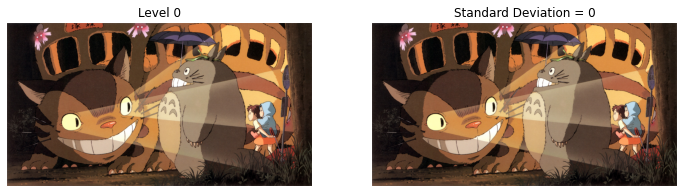

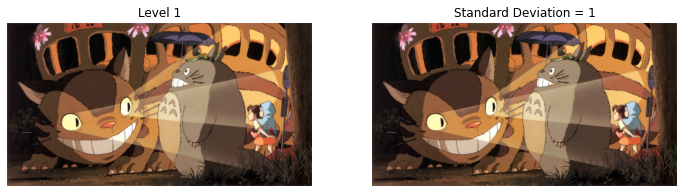

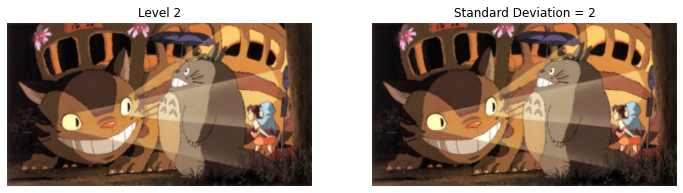

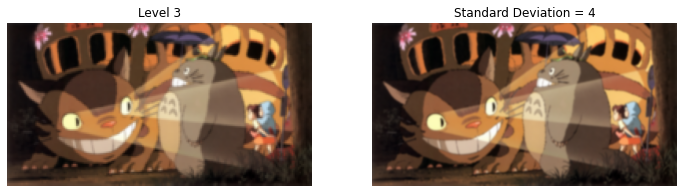

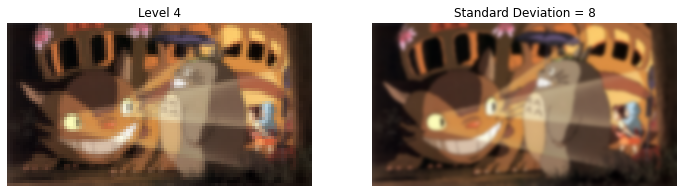

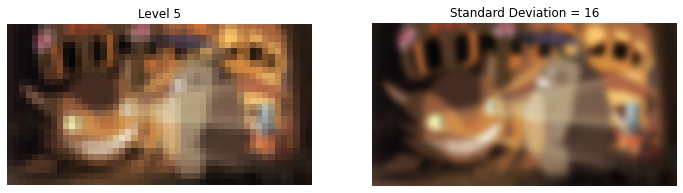

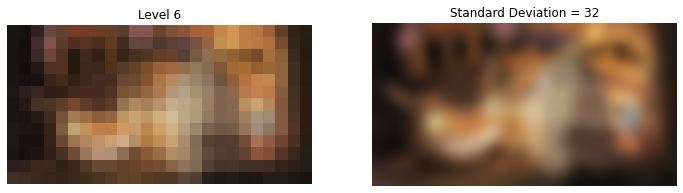

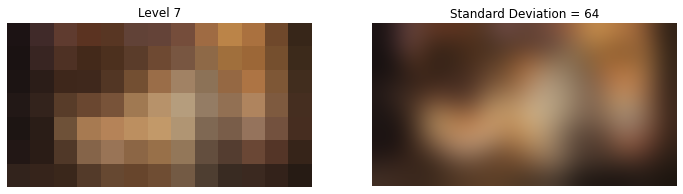

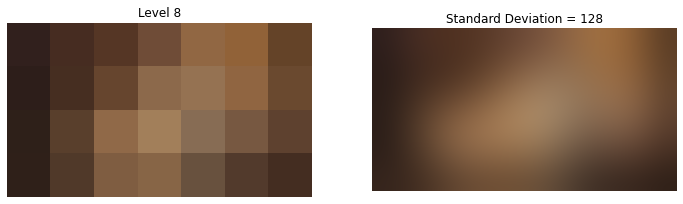

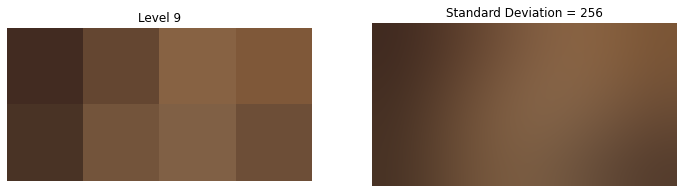

In [ ]:
# from imageio import imread
# if this import gives issues, please use the following
from imageio import imread

img = imread("p1/totoro.jpg")
pyramid = gaussian_pyramid(img,9)
scale_space_rep = scale_space(img,9)
plot_results(pyramid, scale_space_rep)

**Comments on your results:**

----------->YOUR COMMENTS HERE<------------

For the gaussian pyramid plots, we can see that every time we go up a level, we are losing information about the image, which is expected due to the subsampling that has been happening after each iteration. At the end, we are only left with a handful of pixels that do not convey any information about the image we started with. But i do want to say that subsampling also helps in memory issues and storage so it reduces the memory needed to store big images. 

For the scale space, we are not subsampling, and this is why we do not see a pixelated image at the end, because we are preserving the number of pixels we started with. However, the image is also getting more and more blurry after each round, which is also expected because we are averaging pixel values using gaussian kernels. 


----------->COMMENTS END<------------

## Problem 2: Epipolar Geometry | Uncalibrated Stereo [40 points]

In Assignment 2, we worked with calibrated cameras (i.e., calibration matrices $K_1$ and $K_2$, camera rotation matrices $R_1$ and $R_2$, camera translation vectors $t_1$ and $t_2$) to solve calibrated stereo. 

In this problem, we are interested in recovering the stereo information without the use of a calibration process. Specifically, given ground-truth correspondences from a pair of images, your task is to estimate the fundamental matrix and recover the epipolar geometry.

### Problem 2.1 Fundamental matrix [12 points]

Complete the `compute_fundamental` function below using the 8-point algorithm described in lecture. Note that the normalization of the corner points is handled in the `fundamental_matrix` function.

**Hint:** Feel free to use any basic Python packages to solve the singular value decomposition. However, read the corresponding documentation to make sure about the form of parameters and returns.

In [ ]:
def compute_fundamental(x1, x2):
    """    
    Computes the fundamental matrix from corresponding points using the 8 point algorithm.
    Args:
        x1: normalized homogeneous matching points from image1(3xN)
        x2: normalized homogeneous matching points from image2(3xN)
    Returns:
        F: Fundamental Matrix (3x3)
    """
    F = np.ones((3,3))
    A = []
    for i in range(x2.shape[1]):
      temp = []
      for j in range(3):
        for k in range(3):
          temp.append(x2[j,i]*x1[k,i])
      A.append(temp)
    A = np.array(A)
    _,_,V = np.linalg.svd(A)
    U,S,V = np.linalg.svd(V[-1,:].reshape(3,3))
    S[2] = 0
    S = np.diag(S)
    F = np.dot(np.dot(U,S),V)
    return -1*F
    
def fundamental_matrix(x1,x2):
    """    
    Computes the fundamental matrix from corresponding points
    
    Args:
        x1: unnormalized homogeneous points from image1(3xN)
        x2: unnormalized homogeneous points from image2(3xN)
        
    Returns:
        Fundamental Matrix (3x3)
    """
        
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T2.T,np.dot(F,T1))

    return (F/np.linalg.norm(F))

In [ ]:
# TEST CODE, DO NOT MODIFY
# Here is the code for you to test your implementation
# Here, we are using only the first 12 correspondences from the dataset, to test our fundamental matrix
cor1 = np.load("./p2/"+'dino'+"/cor1.npy")[:, :12]
cor2 = np.load("./p2/"+'dino'+"/cor2.npy")[:, :12]
print(fundamental_matrix(cor1, cor2))


# should print 
# [[ 4.38463855e-07 -2.94653450e-06  1.61055253e-03]
#  [ 3.38922505e-06 -3.49464084e-09 -7.05505157e-03]
#  [-3.13268391e-03  6.44947133e-03  9.99948110e-01]]

[[ 4.38463855e-07 -2.94653450e-06  1.61055253e-03]
 [ 3.38922505e-06 -3.49464084e-09 -7.05505157e-03]
 [-3.13268391e-03  6.44947133e-03  9.99948110e-01]]


### Problem 2.2 Epipoles [6 points]

In this part, you are supposed to complete the function <code>compute_epipole</code> to calculate the epipoles for a given fundamental matrix.

In [ ]:
def compute_epipole(F):
    """
    This function computes the epipoles for a given fundamental matrix.
    
    Args:
      F: fundamental matrix
      
    Returns:
      e1: corresponding epipole in image1
      e2: corresponding epipole in image2
    """
    e1 = np.array([0, 0, 0])
    e2 = np.array([0, 0, 0])
    
    _,_,V = np.linalg.svd(F)
    e1 = V[-1]
    e1 = e1/e1[2]

    _,_,V = np.linalg.svd(F.T)
    e2 = V[-1]
    e2 = e2/e2[2]


    return e1,e2

In [ ]:
# TEST CODE, DO NOT MODIFY
# Here is the code for you to test your implementation
F_test = np.array([[1, 7, 2], [8, 8, 2], [3, 3, 6]])
print(compute_epipole(F_test))
# should print 
# (array([-28.0620543 ,  20.43135167,   1.        ]), 
# array([-6.92378997,  3.49545607,  1.        ]))

(array([-28.0620543 ,  20.43135167,   1.        ]), array([-6.92378997,  3.49545607,  1.        ]))


### Problem 2.3: Epipolar Lines [12 points]

For this part, given pairs of images, your task is to plot the epipolar lines in both images for each image pair. You will want to complete the function <code>plot_epipolar_lines</code> using the `fundamental_matrix` function you just got. 
 
The figure below gives you an idea on how the final results look on **dino**. Show your results for **matrix** and **warrior**.
![Dino Epipolar](fig/eg_dino_epipolar_lines.png) 

In [ ]:
def plot_epipolar_lines(img1, img2, F, cor1, cor2):
  assert cor1.shape[0] == 3
  assert cor2.shape[0] == 3
  assert cor1.shape == cor2.shape

  fig = plt.figure(figsize=(15, 15))
  F = fundamental_matrix(cor1, cor2)
  e1,e2 = compute_epipole(F)

  plt.subplot(1,2,1)

  for i in range(len(cor1[0])):
    x = cor1[:,i][0]
    y = cor1[:,i][1]
    z = cor1[:,i][2]
    plt.scatter(x,y, s=10, edgecolors='r', facecolors='none')
    slope = (y-e1[1])/(x-e1[0])
    yinter = y-slope*x
    x1 = 0
    x2 = img1.shape[1]
    y1 = yinter
    y2 = slope*x2+yinter
    plt.plot([x1, x2+1], [y1, y2], color = 'b', linewidth=0.2)
    plt.axis("off")

  plt.imshow(img1)
  plt.subplot(1,2,2)
  for i in range(len(cor2[0])):
    x = cor2[:,i][0]
    y = cor2[:,i][1]
    z = cor2[:,i][2]
    plt.scatter(x,y, s=10, edgecolors='r', facecolors='none')
    slope = (y-e2[1])/(x-e2[0])
    yinter = y-slope*x
    x1 = 0
    x2 = img2.shape[1]
    y1 = yinter
    y2 = slope*x2+yinter
    plt.plot([x1, x2+1], [y1, y2], color = 'b', linewidth=0.2)
    plt.axis("off")
  plt.imshow(img2)

  plt.show()


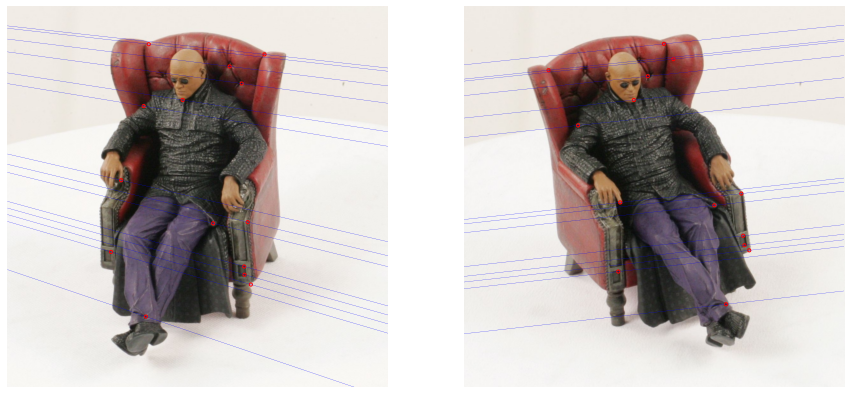

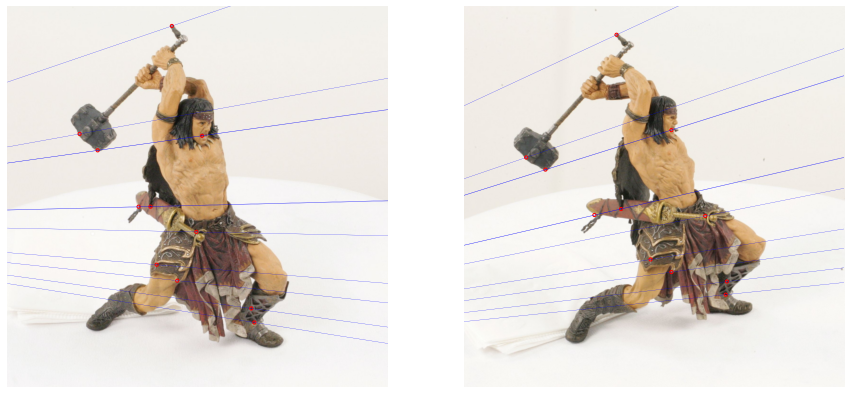

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 
# The total number of outputs is 4 images in 2 pairs

imgids = ["matrix", "warrior"]
for imgid in imgids:
    I1 = imread("./p2/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p2/"+imgid+"/"+imgid+"1.png")
    cor1 = np.load("./p2/"+imgid+"/cor1.npy")
    cor2 = np.load("./p2/"+imgid+"/cor2.npy")
    F = fundamental_matrix(cor1, cor2)
    plot_epipolar_lines(I1,I2,F,cor1,cor2)

### Problem 2.4: Uncalibrated Stereo Image Rectification [10 points]

In Assignment 2, you performed epipolar rectification with calibrated stereo cameras. Rectifying a pair of images can also be done for uncalibrated camera images. Using the fundamental matrix we can find the pair of epipolar lines $\boldsymbol{l_i}$ and $\boldsymbol{l^{'}_i}$ for each of the correspondences. The intersection of these lines will give us the respective epipoles $\boldsymbol{e}$ and $\boldsymbol{e^{'}}$. Now to make the epipolar lines to be parallel we need to map the epipoles to infinity. Hence, we need to find a homography that maps the epipoles to infinity.
 
The rectificaton method has already been implemented for you. You can get more details from the paper *Theory and Practice of Projective Rectification* by Richard Hartley.

Your task is to:

1) complete the `warp_image` function (**Hint:** You may reuse some of the codes from Homework2, but this time we perform the warp of the full image content. The size of the output image is bounded by the **bounding box**).

2) use the given `image_rectification` function to find the rectified images

3) plot the parallel epipolar lines using the `plot_epipolar_lines` function from above.

The figure below gives you an idea on how the final results look (Note that the two images may not be in the same shape). Show your result for **matrix** and **warrior**.
![House Rectification](fig/exp_house_rectify.png) 

In [ ]:
def warp_image(image, H):
  BLeft = np.dot(H,np.array([0,len(image)-1,1]))
  BLeft = np.array([BLeft[1]//BLeft[2],BLeft[0]//BLeft[2]])

  BRight = np.dot(H,np.array([len(image[0])-1,len(image)-1,1]))
  BRight = np.array([BRight[1]//BRight[2],BRight[0]//BRight[2]])

  TLeft = np.dot(H,np.array([0,0,1]))
  TLeft = np.array([TLeft[1]//TLeft[2],TLeft[0]//TLeft[2]])
  
  TRight = np.dot(H,np.array([len(image[0])-1,0,1]))
  TRight = np.array([TRight[1]//TRight[2],TRight[0]//TRight[2]])

  Xmin = min(TLeft[1],BLeft[1])
  Ymin = min(TLeft[0],TRight[0])
  Xmax = max(TRight[1],BRight[1])
  Ymax = max(BLeft[0],BRight[0])


  out_height, out_width = int(Ymax - Ymin), int(Xmax - Xmin)

  out = np.zeros((out_height,out_width,3))
  out = np.array(out,np.int32)

  for x in range(int(Xmin),int(Xmax)):
    for y in range(int(Ymin),int(Ymax)):
      tmp = np.dot(np.linalg.inv(H),[x,y,1])
      final = np.array([tmp[1]//tmp[2],tmp[0]//tmp[2]])
      try:
        if (0 <= final[0] and final[0] <= image.shape[0]) and (0 <= final[1] and final[1] <= image.shape[1]):
          out[int(y-Ymin),int(x-Xmin)] = image[int(final[0]),int(final[1])]
      except Exception as e:
        pass

  out = normalize(out)  
  return out, Xmin, Ymin

In [ ]:
from math import floor, ceil

def compute_matching_homographies(e2, F, im2, points1, points2):
    """This function computes the homographies to get the rectified images.
    
    Args: 
    e2: epipole in image 2
    F: the fundamental matrix (think about what you should be passing: F or F.T!)
    im2: image2
    points1: corner points in image1
    points2: corresponding corner points in image2
    
    Returns:
    H1: homography for image 1
    H2: homography for image 2
    """
    # calculate H2
    width = im2.shape[1]
    height = im2.shape[0]

    T = np.identity(3)
    T[0][2] = -1.0 * width / 2
    T[1][2] = -1.0 * height / 2

    e = T.dot(e2)
    e1_prime = e[0]
    e2_prime = e[1]
    if e1_prime >= 0:
        alpha = 1.0
    else:
        alpha = -1.0

    R = np.identity(3)
    R[0][0] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[0][1] = alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][0] = - alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
    R[1][1] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)

    f = R.dot(e)[0]
    G = np.identity(3)
    G[2][0] = - 1.0 / f

    H2 = np.linalg.inv(T).dot(G.dot(R.dot(T)))

    # calculate H1
    e_prime = np.zeros((3, 3))
    e_prime[0][1] = -e2[2]
    e_prime[0][2] = e2[1]
    e_prime[1][0] = e2[2]
    e_prime[1][2] = -e2[0]
    e_prime[2][0] = -e2[1]
    e_prime[2][1] = e2[0]

    v = np.array([1, 1, 1])
    M = e_prime.dot(F) + np.outer(e2, v)

    points1_hat = H2.dot(M.dot(points1.T)).T
    points2_hat = H2.dot(points2.T).T

    W = points1_hat / points1_hat[:, 2].reshape(-1, 1)
    b = (points2_hat / points2_hat[:, 2].reshape(-1, 1))[:, 0]

    # least square problem
    a1, a2, a3 = np.linalg.lstsq(W, b, rcond=None)[0]
    HA = np.identity(3)
    HA[0] = np.array([a1, a2, a3])

    H1 = HA.dot(H2).dot(M)
    return H1, H2

In [ ]:
def image_rectification(im1, im2, points1, points2):
    """This function provides the rectified images along with the new corner points as
    images with corner correspondences
    
    Args:
    im1: image1
    im2: image2
    points1: corner points in image1
    points2: corner points in image2
    
    Returns:
    rectified_im1: rectified image 1
    rectified_im2: rectified image 2
    new_cor1: new corners in the rectified image 1
    new_cor2: new corners in the rectified image 2
    """
    F = fundamental_matrix(points1, points2)
    e1, e2 = compute_epipole(F)
    H1, H2 = compute_matching_homographies(e2, F, im2, points1.T, points2.T)
    
    # Apply homographies
    rectified_im1, min_x1, min_y1 = warp_image(im1, H1)
    rectified_im2, min_x2, min_y2 = warp_image(im2, H2)

    new_cor1 = np.dot(H1, points1) # 3 x n
    new_cor1 /= new_cor1[-1, :]
    new_cor1[0, :] -= min_x1
    new_cor1[1, :] -= min_y1
    new_cor2 = np.dot(H2, points2)
    new_cor2 /= new_cor2[-1, :]
    new_cor2[0, :] -= min_x2
    new_cor2[1, :] -= min_y2
    return rectified_im1, rectified_im2, new_cor1, new_cor2

./p2/matrix/matrix0.png


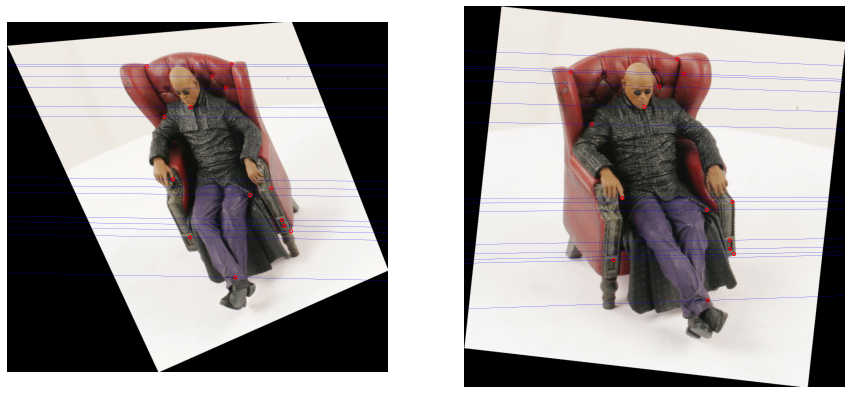

./p2/warrior/warrior0.png


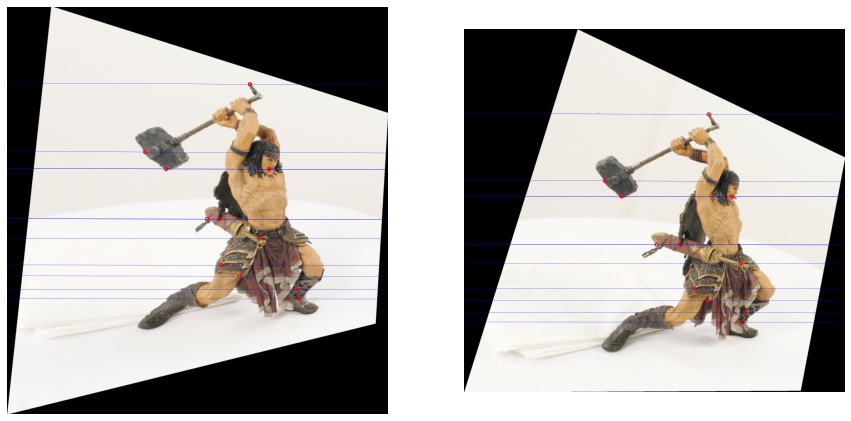

In [ ]:
imgids = ["matrix", "warrior"]
for imgid in imgids:
    print("./p2/"+imgid+"/"+imgid+"0.png")
    I1 = imread("./p2/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p2/"+imgid+"/"+imgid+"1.png")
    
    cor1 = np.load("./p2/"+imgid+"/cor1.npy")
    cor2 = np.load("./p2/"+imgid+"/cor2.npy")
    rectified_im1, rectified_im2, new_cor1, new_cor2 = image_rectification(I1, I2, cor1, cor2)
    F = fundamental_matrix(new_cor1, new_cor2)
    plot_epipolar_lines(rectified_im1,rectified_im2,F,new_cor1,new_cor2)

## Problem 3: Fundamental Matrix Estimation with RANSAC [40 pts]

In problem 2, you have `fundamental_matrix` function which calculates the fundamental matrix $F$ from matching pairs of points in two different images. In this problem, we will first implement a SIFT (Scale-Invariant Feature Transform)-pipeline that detects feature points and identifies matching points between two images. Then we estimate the fundamental matrix $F$ with those matching points using RANSAC method.

**Instruction:** You can use basic functions/objects in OpenCV, but you **may not use** functions that directly solve the problem unless specified.

### Problem 3.1: SIFT Feature Detection [5 pts]

Let's get some experience with SIFT detection. You may refer to [SIFT Python tutorial](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) and OpenCV [cv::SIFT Class Reference](https://docs.opencv.org/4.x/d7/d60/classcv_1_1SIFT.html) according to your OpenCV version. For more details and understanding, reading [the original paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) is highly recommended. 

The following example plots keypoints on `p2/dino/dino0.png`. Your task is to plot a similar image for `p2/dino/dino1.png`.
<center><img src="fig/eg_dino_sift.png" alt="DINO SIFT" width="400" align="center"/></center>

**For this part ONLY(Problem 3.1), you will use any OpenCV functions you need.**

In [ ]:
import cv2 
def get_sift_features_plot(image):
    """This function draws SIFT features
    
    Args:
    image:rgb image
    
    Returns:
    keypoint_image: image with key points drawn on
    """
    keypoint_image = image.copy()
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(keypoint_image,None)
    keypoint_image=cv2.drawKeypoints(keypoint_image,kp,keypoint_image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return keypoint_image


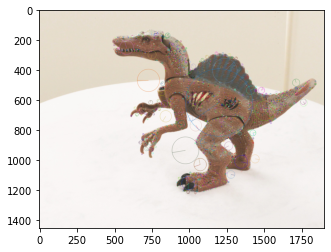

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 
image = imread('p2/dino/dino1.png')
keypointimage = get_sift_features_plot(image)
plt.imshow(keypointimage)

### Problem 3.2: SIFT Feature Matching [10 pts]

Let's try to match the SIFT features from a pair of images. You will be using [cv::BFMatcher](https://docs.opencv.org/4.x/d3/da1/classcv_1_1BFMatcher.html), a Brute-force descriptor matcher in OpenCV. Also, we will draw lines between the features that match in both the images like you did in Homework 2. However, you will use [OpenCV Drawing Functions](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html) this time.
Complete the `get_matches_sift` and `create_matching_image` functions to draw a pair of matched images. The following example plots the result for **dino**, your task is to plot the result for **skull-book**.
![DINO MATCHING](fig/eg_dino_sift_matching.png)
For this part(Problem 3.2), you will use `cv::BFMatcher` and `cv::SIFT` related modules from OpenCV library.

In [ ]:
import random

def get_matches_sift(img1, img2):
    corners1 = []
    corners2 = []
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)
    matcher = cv2.BFMatcher(crossCheck=True) 
    matches = matcher.match(desc1,desc2)

    for mat in matches:
      corners1.append(kp1[mat.queryIdx].pt)
      corners2.append(kp2[mat.trainIdx].pt)
    corners1 = np.array(corners1)
    corners2 = np.array(corners2)  
    return corners1, corners2


def create_matching_image(img1, img2, corners1, corners2):
    """This function create a matching result image from a pair of images
       and their correspondences.
    Args:
        img1: rgb image1
        img2: rgb image2
        corners1: matching points in image1 in image coordinates(Nx2)
        corners2: matching points in image2 in image coordinates(Nx2)
    Returns:
        matching_img: the result rgb matching image. 
    """
    """ ==========
    YOUR CODE HERE
    ========== """
    h1, w1, _ = img1.shape;h2, w2, _ = img2.shape
    height = max(h1, h2); width = w1+w2
    matching_img = np.zeros((height, width, 3), dtype=img1.dtype)
    matching_img = np.hstack((img1, img2))

    for i in range(len(corners1)):
      r = random.randint(0,255)
      g = random.randint(0,255)
      b = random.randint(0,255)
      rgb = [r,g,b]
      cv2.line(matching_img, (int(corners1[i][0]),int(corners1[i][1])), (int(corners2[i][0]+w1),int(corners2[i][1])),rgb,4)
    return matching_img



Found 2751 possibly matching features


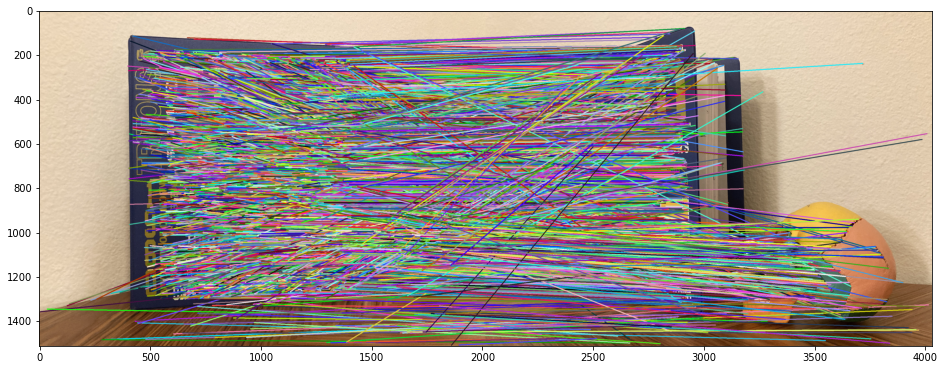

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 

# read images
img1 = imread('p3/skull-book1.jpg')  
img2 = imread('p3/skull-book2.jpg') 

corners1, corners2 = get_matches_sift(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY),\
                                      cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))

print('Found {:d} possibly matching features'.format(corners1.shape[0]))
match_image = create_matching_image(img1, img2, corners1, corners2)
plt.figure(figsize=(16,8));plt.imshow(match_image); plt.show()

### Problem 3.3: Calculate the Fundamental Matrix using RANSAC [25 pts]

Now you have `fundamental_matrix` function which calculates the fundamental matrix $F$ and a set of potential matching points using SIFT and BFMatcher. However, as you see from Problem 3.2, unlike the Problem 2, the SIFT-pipeline doesn't guarantee that those points are perfectly matched. Therefore, we will implement the RANdom SAmple Consensus (RANSAC) method from the lecture to search through the potential matching points and remove those false-matches(outliers) to use for calculating the fundamental matrix.

Complete `fundamental_matrix_ransac` to estimate fundamental matrix with RANSAC method. You will implement `compute_consensus_set` as a building block to find a consensus set. You will also complete functions to calculate distance as points to epipolar line distance(`point2line_dist`).

In [ ]:
def to_homog(points):
    """convert points from euclidean to homogeneous
    """
    m, n = points.shape
    homo_points = np.vstack((points, np.ones(n)))
    return homo_points

def from_homogeneous(pt):
    return np.array([pt[0]/pt[2],pt[1]/pt[2]])

def point2line_dist(point, line):
    nonhomo = from_homogeneous(point)
    x = nonhomo[0]
    y = nonhomo[1]
    a, b, c = line[0], line[1], line[2]
    numi = abs(a*x+b*y+c)
    denum = np.sqrt(a**2+b**2)
    distance = numi/denum
    return distance

def compute_consensus_set(x1, x2, F, threshold):
    inliers = []
    for i in range(x1.shape[1]):
        pt1 = x1[:, i]
        pt2 = x2[:, i]
        line1 = np.dot(F,pt1)
        line2 = np.dot(F.T,pt2)
        dst = abs(point2line_dist(pt1,line2)) + abs(point2line_dist(pt2,line1))
        if dst<threshold:
            inliers.append(i)
    return np.array(inliers)
    
def compute_N(p, s, inlier_p):
    if inlier_p>0.99:
        return 0
    return int(np.log(1 - p) / np.log(1 - inlier_p ** s))


In [ ]:
def fundamental_matrix_ransac(x1, x2, threshold=100, confidence=0.95, iter_limit=5000):
    num_points = len(x1[0])
    best_inliers_num = 0
    best_F = np.ones((3,3))
    s = 8
    x1_inliers = []
    x2_inliers = []
    indices = []
    for i in range(iter_limit):
      samples = random.sample(range(0, num_points), s)
      pt1 = x1[:,samples]
      pt2 = x2[:,samples]
      F = fundamental_matrix(to_homog(pt1),to_homog(pt2))
      inliers = compute_consensus_set(to_homog(x1), to_homog(x2), F, threshold)

      if inliers.shape[0] > best_inliers_num:
          best_inliers_num = inliers.shape[0]
          best_F = F
          indices = inliers

    for i in range(len(indices)):
        x1_inliers.append(x1[:,indices[i]])
        x2_inliers.append(x2[:,indices[i]])
            
    x1_inliers = np.array(x1_inliers)
    x2_inliers = np.array(x2_inliers)
        
    print('Total Number of inliers {}'.format(best_inliers_num))
    return best_F, x1_inliers.T, x2_inliers.T


First, test your implementation on **warrior** with ground truth matches. The two pairs of images 1) the matching pair with F estimated from the whole set set of corners and 2) the matching pair with F estimated with RANSAC method. The two matching pairs should look very similar.

./p2/warrior/warrior0.png
Found 11 possibly matching features
Total Number of inliers 11

	F estimated with whole set of points				 F estimated with RANSAC


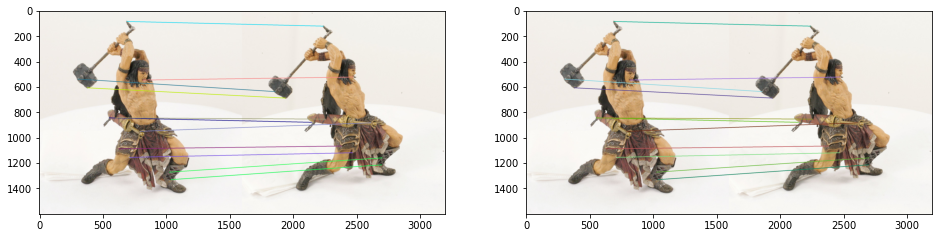

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results. 

imgids = [ "warrior"]
for imgid in imgids:
    print("./p2/"+imgid+"/"+imgid+"0.png")
    I1 = imread("./p2/"+imgid+"/"+imgid+"0.png")
    I2 = imread("./p2/"+imgid+"/"+imgid+"1.png")
    
    cor1 = np.load("./p2/"+imgid+"/cor1.npy")
    cor2 = np.load("./p2/"+imgid+"/cor2.npy")
    
    print('Found {:d} possibly matching features'.format(cor1.shape[1]))
    
#     F_all = fundamental_matrix(cor1, cor2)
    match_image_all = create_matching_image(I1, I2, cor1.T, cor2.T)
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1); plt.imshow(match_image_all);

    F, x1_in, x2_in = fundamental_matrix_ransac(cor1[:2,:], cor2[:2,:])
    match_image = create_matching_image(I1, I2, x1_in.T, x2_in.T)
    print('\n\tF estimated with whole set of points\t\t\t\t F estimated with RANSAC')
    
    plt.subplot(1,2,2); plt.imshow(match_image); plt.show()   


Then, show your results for **skull-book**. You can tweak the parameters to `fundamental_matrix_ransac` to optimize your results. 

In [ ]:
# PLOT CODE: DO NOT CHANGE
# This code is for you to plot the results.  

def plot_matching_origin(I1, I2, corners1, corners2):
#     F_all = fundamental_matrix(to_homog(corners1.T), to_homog(corners2.T))
    match_image_all = create_matching_image(I1, I2, corners1, corners2)
    print('\n F estimated with whole set of points')
    plt.figure(figsize=(16,8)); plt.imshow(match_image_all)

def plot_matching_RANSAC(I1, I2, corners1, corners2, thresh):
    F, x1_in, x2_in = fundamental_matrix_ransac(corners1.T, corners2.T, threshold=thresh)
    match_image = create_matching_image(I1, I2, x1_in.T, x2_in.T)
    print('F estimated with RANSAC, Dist threshold='+str(thresh))
    plt.figure(figsize=(16,8)); plt.imshow(match_image);


In [ ]:
# LOAD CODE: DO NOT MODIFY
I1 = imread("./p3/skull-book1.jpg");scale_a=0.5;
I2 = imread("./p3/skull-book2.jpg");scale_b=0.5;

I1 = cv2.resize(I1, \
                (int(I1.shape[1] * scale_a), int(I1.shape[0] * scale_a)),\
                interpolation = cv2.INTER_AREA)
I2 = cv2.resize(I2, \
                (int(I2.shape[1] * scale_b), int(I2.shape[0] * scale_b)),\
                interpolation = cv2.INTER_AREA)

corners1, corners2 = get_matches_sift(cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY),\
                                  cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY))
print('Found {:d} possibly matching features'.format(corners1.shape[0]))



Found 1193 possibly matching features



 F estimated with whole set of points


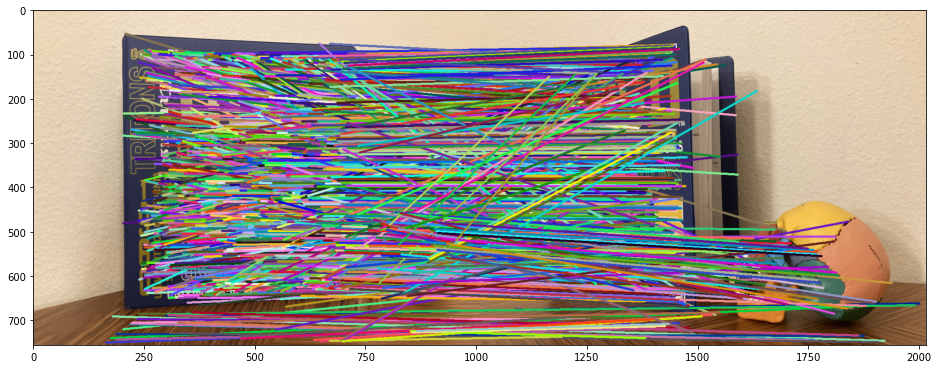

In [ ]:
# PLOT CODE: DO NOT MODIFY

plot_matching_origin(I1, I2, corners1, corners2)
plt.show()

Total Number of inliers 227
F estimated with RANSAC, Dist threshold=1


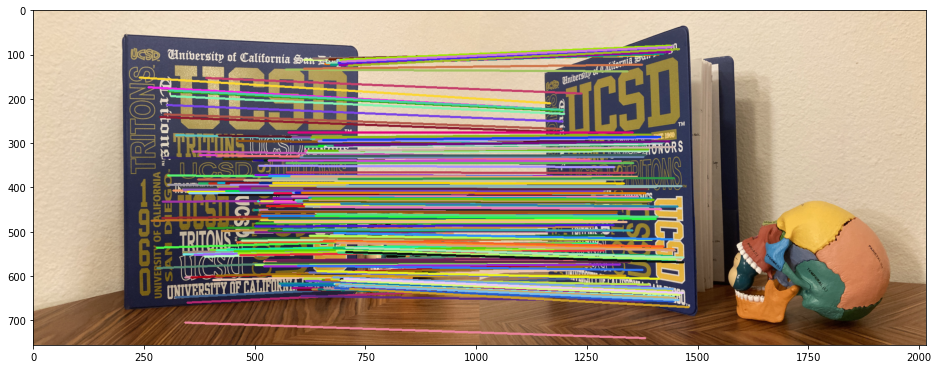

In [ ]:
thresh = 1 #You can tweak this

#PLOT CODE: DO NOT MODIFY
plot_matching_RANSAC(I1, I2, corners1, corners2, thresh)
plt.show()

Total Number of inliers 230


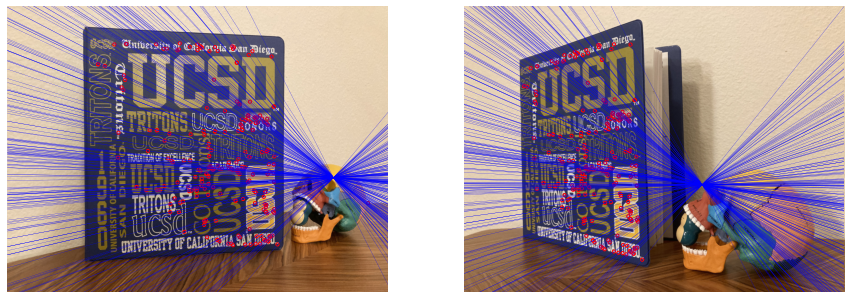

In [ ]:
I1 = imread("./p3/skull-book1.jpg");scale_a=0.5;
I2 = imread("./p3/skull-book2.jpg");scale_b=0.5;

I1 = cv2.resize(I1, \
                (int(I1.shape[1] * scale_a), int(I1.shape[0] * scale_a)),\
                interpolation = cv2.INTER_AREA)
I2 = cv2.resize(I2, \
                (int(I2.shape[1] * scale_b), int(I2.shape[0] * scale_b)),\
                interpolation = cv2.INTER_AREA)

""" ==========
YOUR CODE HERE
========== """

c1, c2 = get_matches_sift(cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY),\
                                  cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY))
best_F, x1_inl, x2_inl = fundamental_matrix_ransac(c1.T, c2.T, threshold=1)
plot_epipolar_lines(I1,I2,best_F,to_homog(x1_inl), to_homog(x2_inl))


## Problem 4: Optical Flow [15 pts]

In this problem, we will implement the multi-resolution Lucas-Kanade algorithm to estimate optical flow.

An example optical flow output is shown below - this is not a solution, just an example output.

![title](fig/sample_optical_flow_output.PNG)

### Problem 4.1: Lucas-Kanade implementation [15 pts]

Implement the Lucas-Kanade method for estimating optical ﬂow. Fill in the function `compute_LK`.

In [ ]:
def zero_pad(image, pad_top, pad_down, pad_left, pad_right):
    new_image = np.zeros((int(len(image)+2*pad_top) , int(len(image[0])+2*pad_left))) 
    new_image[pad_top:image.shape[0]+pad_top, pad_left:image.shape[1]+pad_left] = image
    return new_image

def conv(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    kernel = np.flipud(kernel)
    kernel = np.fliplr(kernel)
    image = zero_pad(image,(Hk-1)//2,(Hk-1)//2,(Wk-1)//2,(Wk-1)//2)
    out = np.zeros((Hi, Wi))
    for i in range(len(image)-Hk+1):
      for j in range(len(image[0])-Wk+1):
        temp = image[i:i+Hk,j:j+Wk]
        result = np.sum(np.multiply(temp,kernel))
        out[i][j] = result
    return out

def gradient_Gx_Gy(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    dx = np.array([-0.5,0,0.5]).reshape(1,3)
    dy = np.array([[-0.5],[0],[0.5]]).reshape(3,1)
    Gx = np.array(conv(image, dx))
    Gy = np.array(conv(image, dy))
    return Gx,Gy 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,-V1)
    plt.title(titleStr)
    plt.show()


In [ ]:
images=[]
for i in range(1,5):
    # each image after converting to gray scale is of size -> 400x288
    images.append(plt.imread('p4/im'+str(i)+'.png')[:,:288,:])

In [ ]:
def compute_LK(img1, img2, window, u_prev=None, v_prev=None):
    height, width = img1.shape
    padsize = window//2
    sum_mat = np.ones((window,window))
    Gx,Gy = gradient_Gx_Gy(img1)
    fx2 = Gx*Gx
    fy2 = Gy*Gy
    fxy = Gx*Gy 
    fx2 = np.array(conv(fx2,sum_mat))
    fy2 = np.array(conv(fy2,sum_mat))
    fxy = np.array(conv(fxy,sum_mat))
    dt = img1 - img2
    Ixt = Gx*dt
    Iyt = Gy*dt
    Fxt = np.array(conv(Ixt,sum_mat))
    Fyt = np.array(conv(Iyt,sum_mat))
    U = np.zeros((img1.shape[0],img1.shape[1]))
    V = np.zeros((img2.shape[0],img2.shape[1]))

    for i in range(padsize,len(img2)-padsize):
      for j in range(padsize,len(img2[0])-padsize):
        M = [[fx2[i,j],fxy[i,j]],[fxy[i,j],fy2[i,j]]]
        b = np.array([-Fxt[i,j],-Fyt[i,j]])
        final = np.dot(np.linalg.pinv(M),b.T)
        U[i][j] = final[0]
        V[i][j] = final[1]

    return U, V

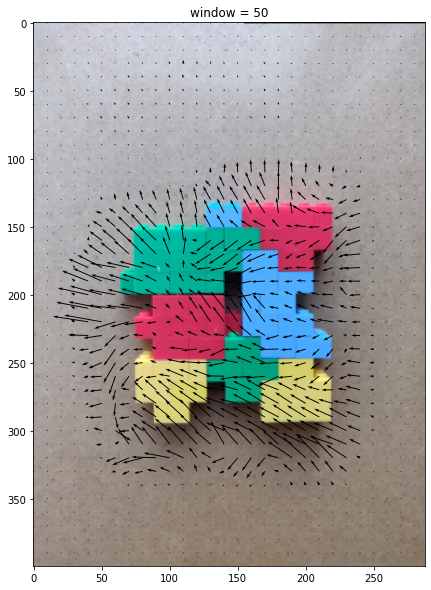

In [ ]:
# PLOT CODE: DO NOT MODIFY
## Test your implementation on sample parameter values
window = 50
U, V = compute_LK(grayscale(images[0]),grayscale(images[1]), window)
# Plot
plot_optical_flow(images[0],U,V, 'window = '+str(window))

**Test with different Window size:**

Plot optical ﬂow for the pair of images im1 and im2 for at least 4 diﬀerent window sizes which leads to observable diﬀerence in the results. We have provided the different window sizes. Comment on the eﬀect of window size on results and justify.

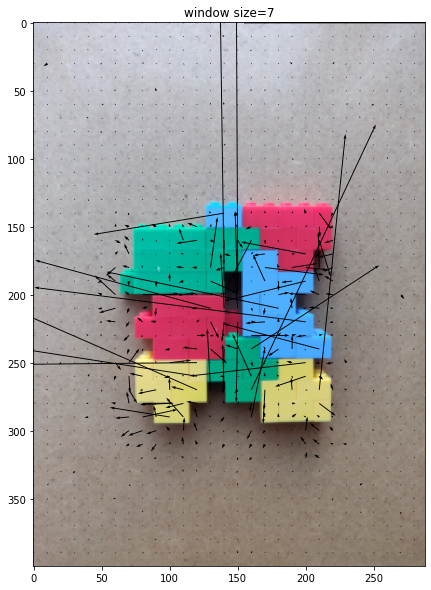

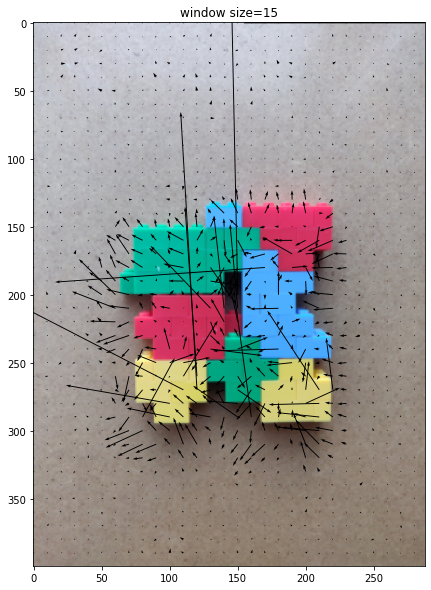

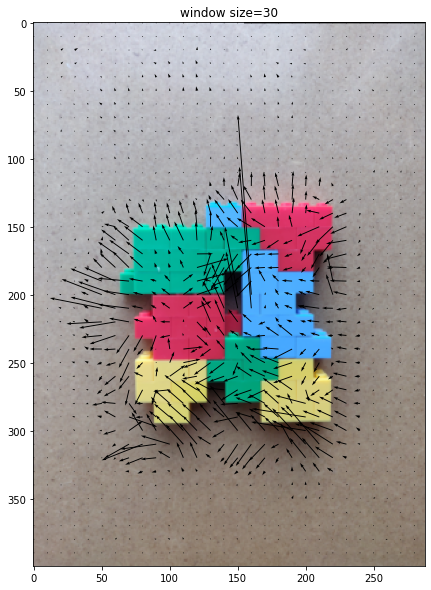

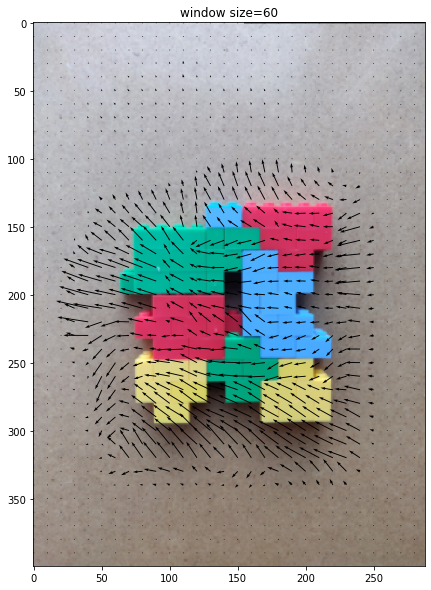

In [ ]:
windows=[7, 15, 30, 60]

for i in range(4):
    U,V=compute_LK(grayscale(images[0]),grayscale(images[1]),windows[i])
    plot_optical_flow(images[0],U,V,'window size='+str(windows[i]))

We see that results are significantly better and more consistent when window sizes are larger in this example of the implementation of the LK algorithm. 
The changes appear to be way too big for the smallest window size in this case and that is why it is not able to grasp them correctly. 

As the window size is increasing, we are noticing that the results get better and better until we try the biggest window size (60) and the results are really smooth and accurate.

The Lucas-Kanade algorithm with small window sizes works well when there is minimal change between the photos. As a result, only the biggest window size in this case is able to effectively capture the majority of the differences between the two images and the results actually turned out to be amazing.

### Problem 4.2: Multi-resolution Lucas-Kanade implementation[Optional][0 pts]

**NOTE: This problem is optional. Your submission for this problem would be graded but you would not receive a score for solving this problem. However, you are welcome and encouraged to try it out and bring any questions that you have to the instructional team.**


Implement the Lucas-Kanade method for estimating optical flow. The function `LucasKanadeMultiScale` needs to be completed. You can implement `upsample_flow` and `OpticalFlowRefine` as 2 building blocks in order to complete this.

In [ ]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from previous level
    Args:
        u_prev, v_prev: optical flow from prev level
    Returns:
        u, v: upsampled optical flow to the current level
    '''
    """ ==========
    YOUR CODE HERE
    ========== """
    

    return u, v

def OpticalFlowRefine(im1,im2,window, u_prev=None, v_prev=None):
    '''
    Inputs: the two images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''   
    """ ==========
    YOUR CODE HERE
    ========== """
    

    return u, v

In [ ]:
from skimage.transform import resize

def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    
    """ ==========
    YOUR CODE HERE
    ========== """
    # You can call OpticalFlowRefine iteratively

    
    return u, v

In [ ]:
numLevels=5
window = 17
U, V = LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
# # Plot
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

#### Problem 4.2.2: Number of levels

Plot optical flow for the pair of images im1 and im2 for different number of levels mentioned below. Comment on the results and justify.<br>
(i) window size = 13, numLevels = 1<br>
(ii) window size = 13, numLevels = 3<br>
(iii) window size = 13, numLevels = 5<br>
So, you are expected to provide 3 outputs here<br>

Note: if numLevels = 1, then it means the optical flow is only computed at the image resolution i.e. no downsampling

In [ ]:
# Example code to generate output
numLevels=1
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=3
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
# Plot
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

numLevels=5
U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                          window,numLevels)
# Plot
plot_optical_flow(images[0],U,V, \
                  'levels = ' + str(numLevels) + ', window = '+str(window))

**Your comments here**

#### Problem 4.2.3: Window size

Plot optical flow for the pair of images im1 and im2 for at least 3 different window sizes which leads to observable difference in the results. Comment on the effect of window size on results and justify. For this part fix the number of levels to be 3.

In [ ]:
# Example code, change as required
numLevels=3

w1, w2, w3 = 7, 11, 17
for window in [w1, w2, w3]:
    U,V=LucasKanadeMultiScale(grayscale(images[0]),grayscale(images[1]),\
                              window,numLevels)
    plot_optical_flow(images[0],U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

**Your comments here**

#### Problem 4.2.4 All pairs

Find optical ﬂow for the pairs (im1,im2), (im1,im3), (im1,im4) for a range of window sizes. Submit the best result for each pair. Does the optical ﬂow result seem consistent with visual inspection? Comment on the type of motion indicated by results and visual inspection and explain why they might be consistent or inconsistent.

In [ ]:
# use one fixed window and numLevels for all pairs
numLevels = 5
window = 17
""" ==========
YOUR CODE HERE
========== """
img0 = images[0]
for i, image in enumerate(images):
    if(i==0):
        continue
    img_new = images[i]
    U,V = LucasKanadeMultiScale(grayscale(img0),grayscale(img_new),\
                              window,numLevels)
    print("Image 1, Image ",(i+1))
    # Plot
    plot_optical_flow(img0,U,V, \
                      'levels = ' + str(numLevels) + ', window = '+str(window))

**Your comments here**